In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as stats
import copy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


Source: https://github.com/masoud-akbarzadeh/course_objective_analysis/blob/main/code/testing_spectral_significance.ipynb

In [9]:
# get the data from csv file to numpy array
data = pd.read_csv('era_interim_SH_eke_300hPa.csv')
data = data.to_numpy()
eke = data

In [10]:
# input parameters
T = 256
N = 40
alpha = 0.5

In [11]:
# define your timesteps and frequencies
T2 = T/2
freq = np.arange(0., T2+1.)/T

In [12]:
N = len(eke) // T

# Construct your red noise null hypothesis
Using the equations from class, we can construct the power spectrum of an infinitely long red-noise time series with lag-one autocorrelation of alpha

In [13]:
# contstruct expected rednoise spectrum
rspec = []
for i in np.arange(1,T2+2,1):
    rspec.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/T2)+alpha*alpha))

In [14]:
# sum = 0
# for i in range (len(freq)):
#     sum +=  freq[i] * p[i]
    
    

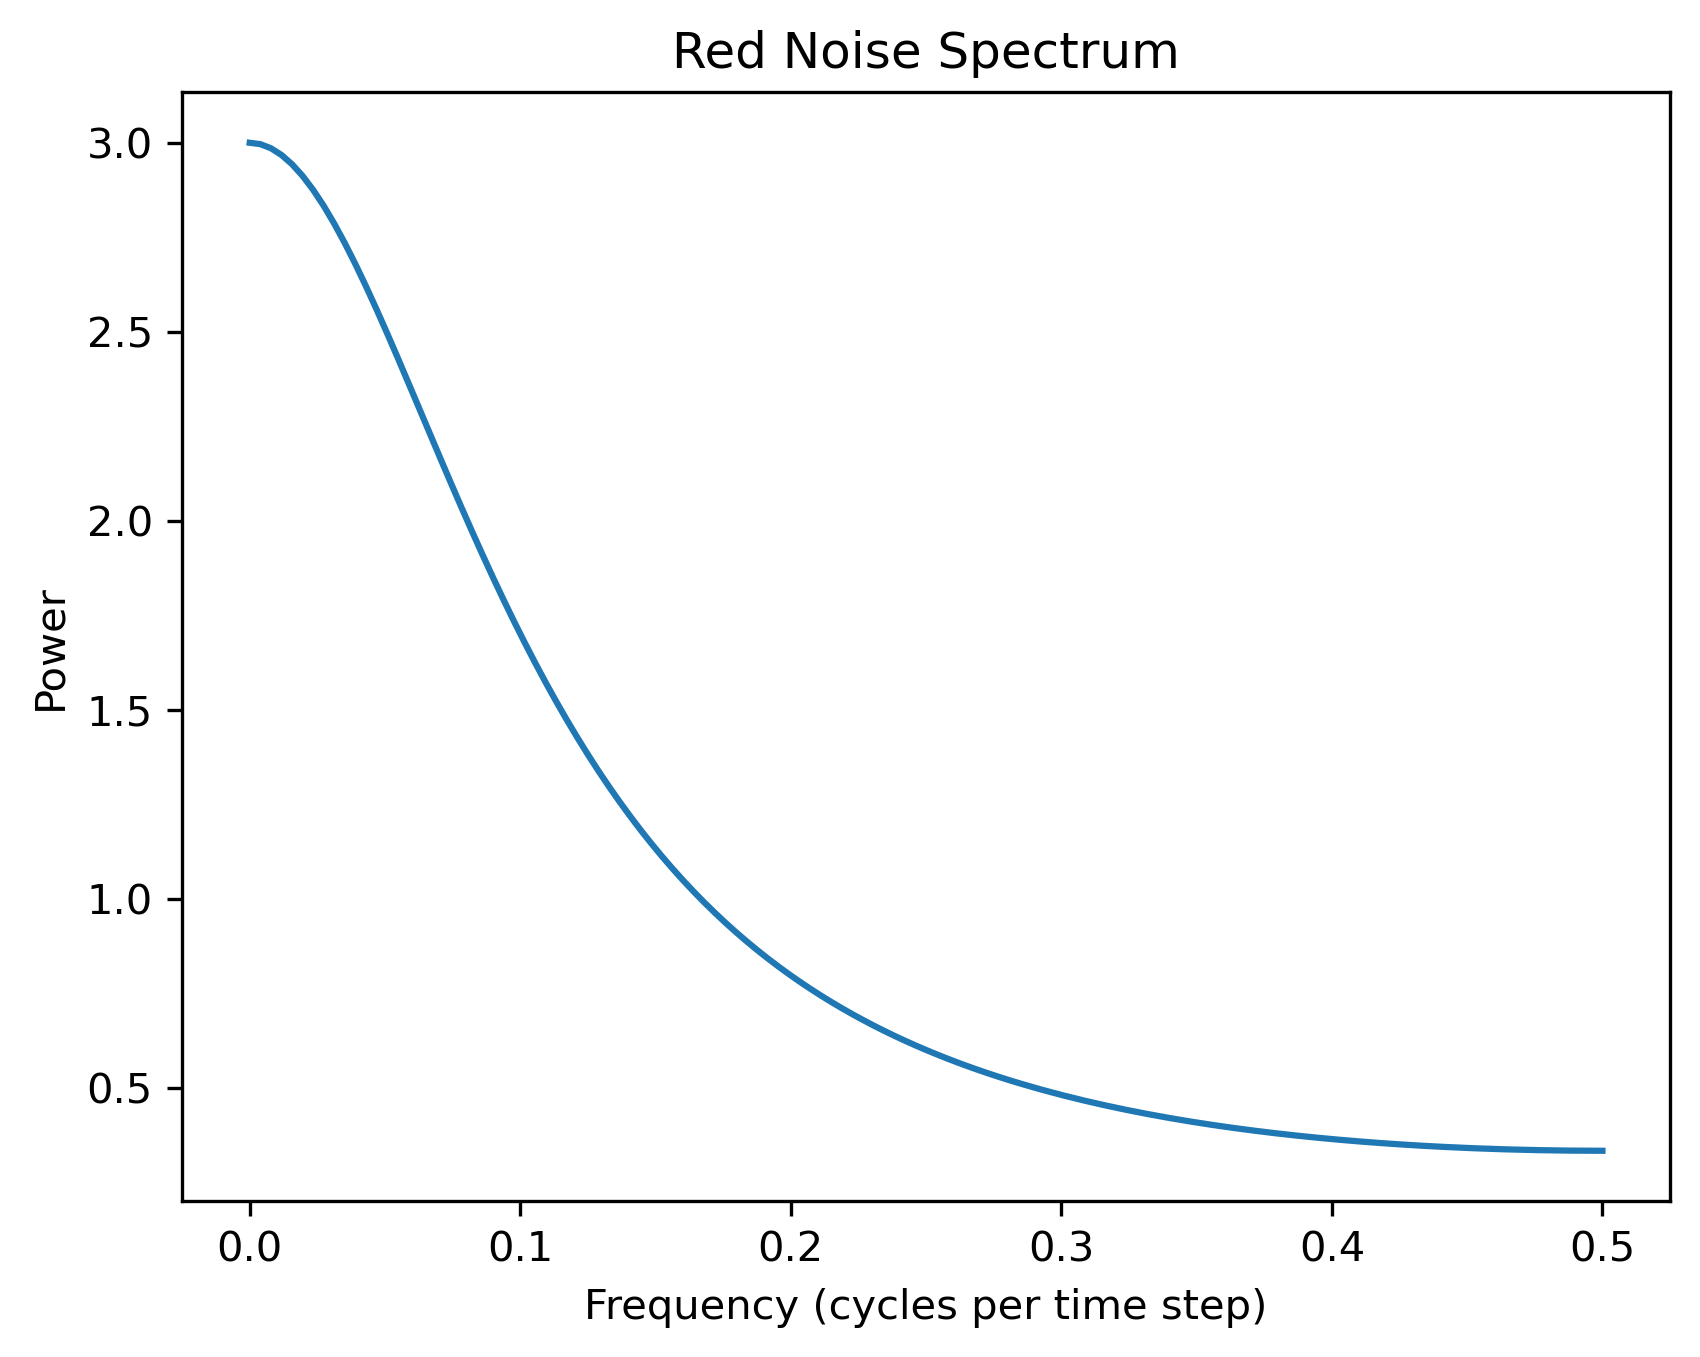

In [15]:
# plot the red noise spectrum
plt.plot(freq, rspec)
plt.xlabel('Frequency (cycles per time step)')
plt.ylabel('Power')
plt.title('Red Noise Spectrum')
plt.show()


Analyze your data (and compare to red noise null)
The code below has two pieces. The first piece is to create fake data (x) to act as your observations. We start with a red-noise time series with the same lag-one autocorrelation of alpha. But then, we add a cosine to it to give it some power at one particular frequency (50/256 = 0.2 cycles per time step). We will loop through this the number of realizations (N) that have been specified.

The idea is that as we average more and more realizations together the true signal of cosine with frequency 0.2 cycles/time step should emerge from the "noise" and distinguish itself as being outside of our 99% bounds of the red-noise null hypothesis.

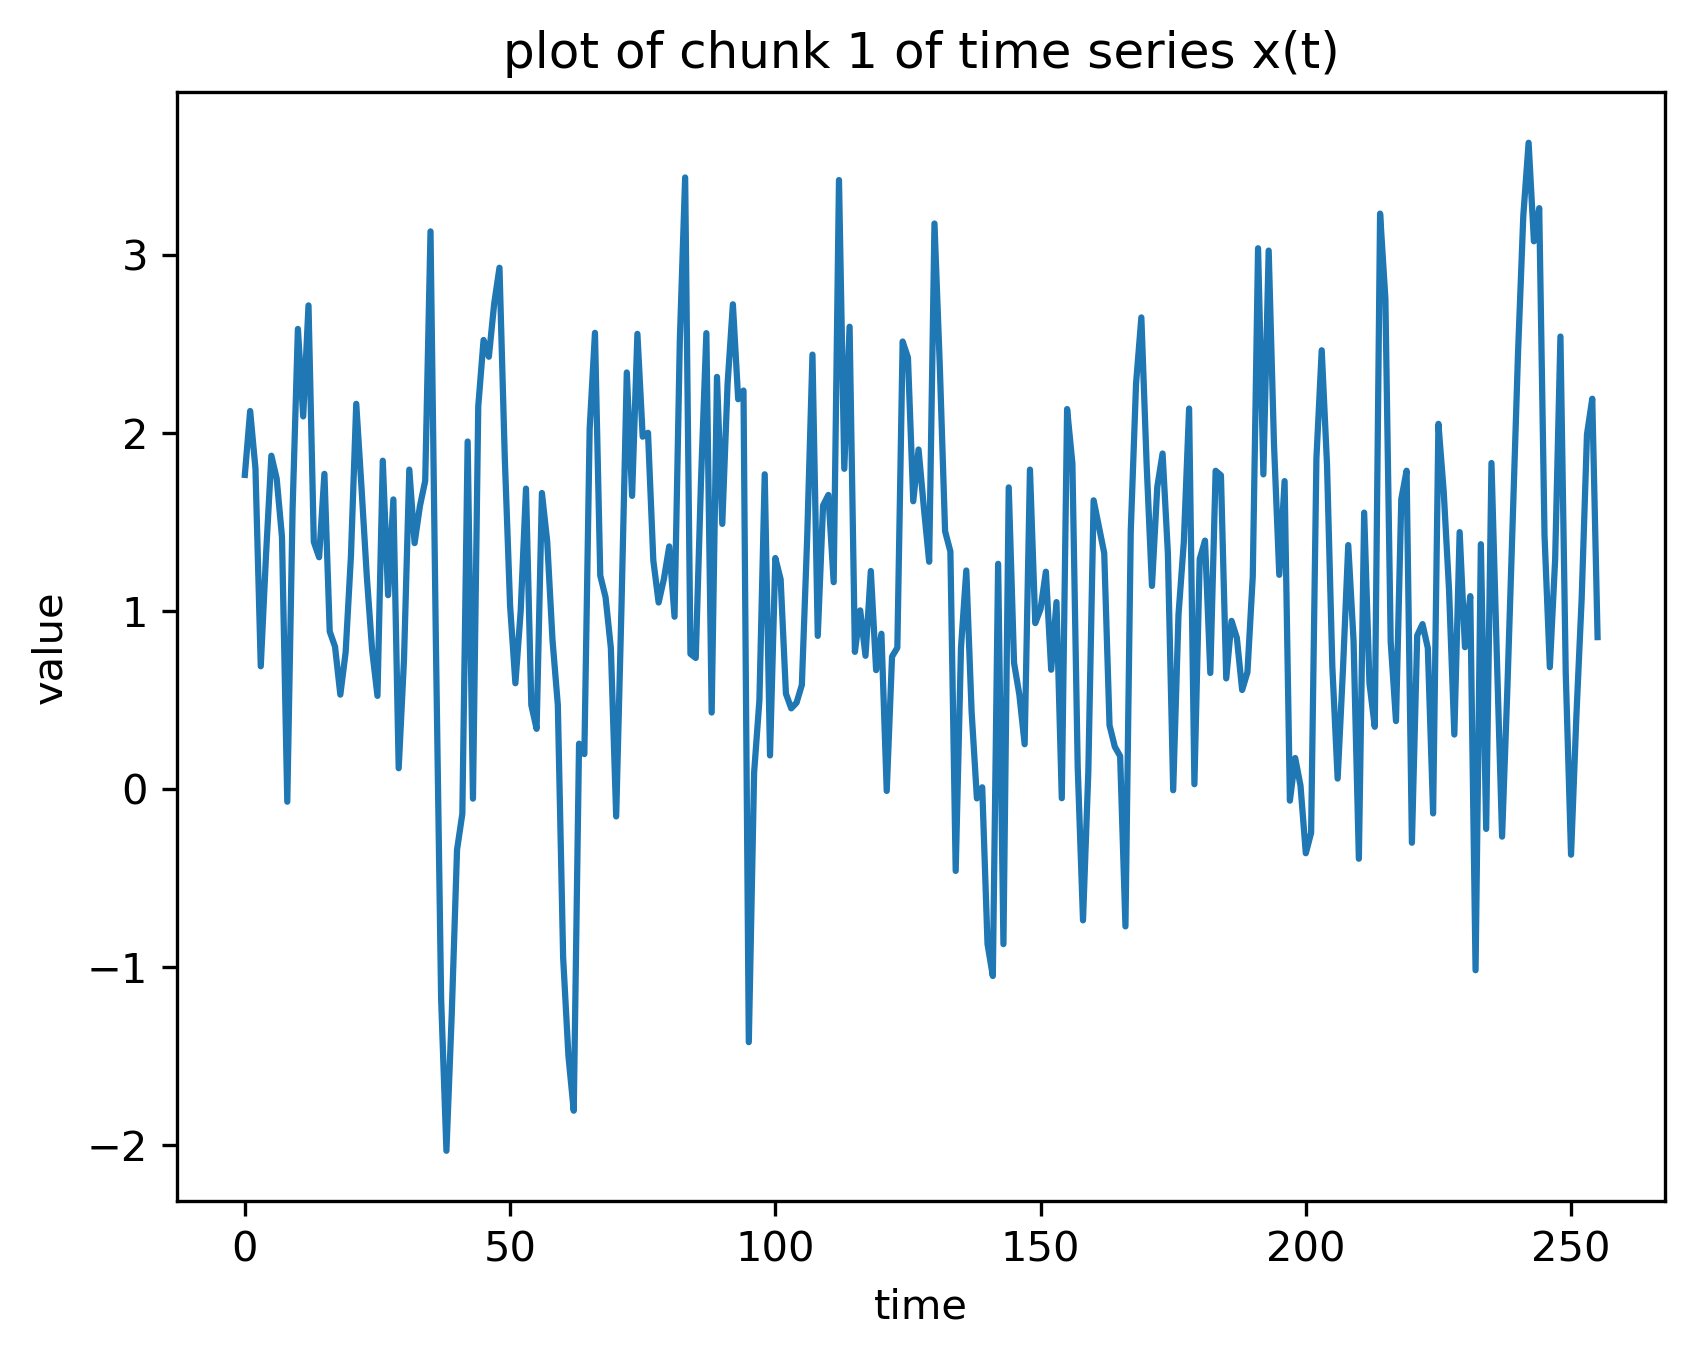

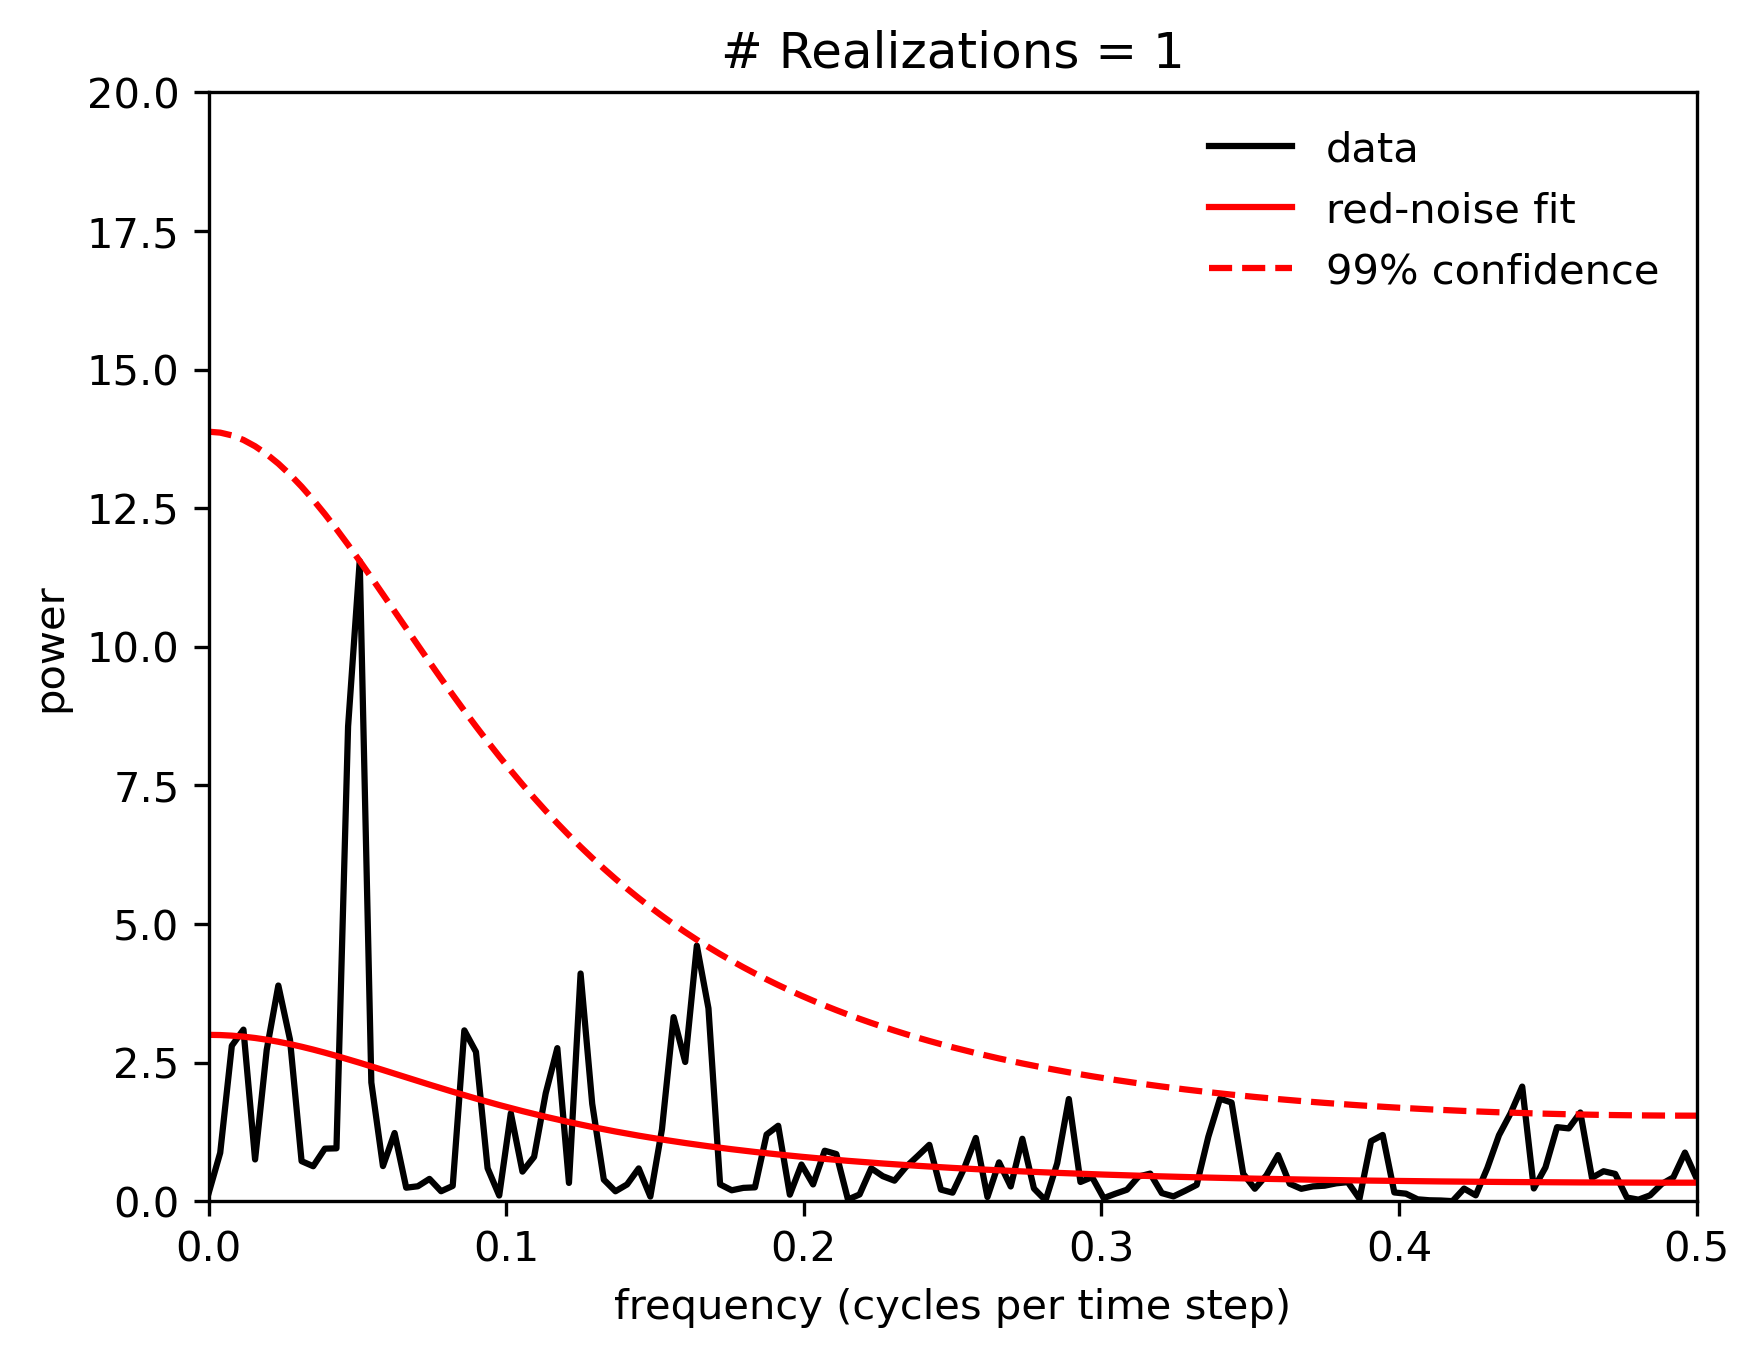

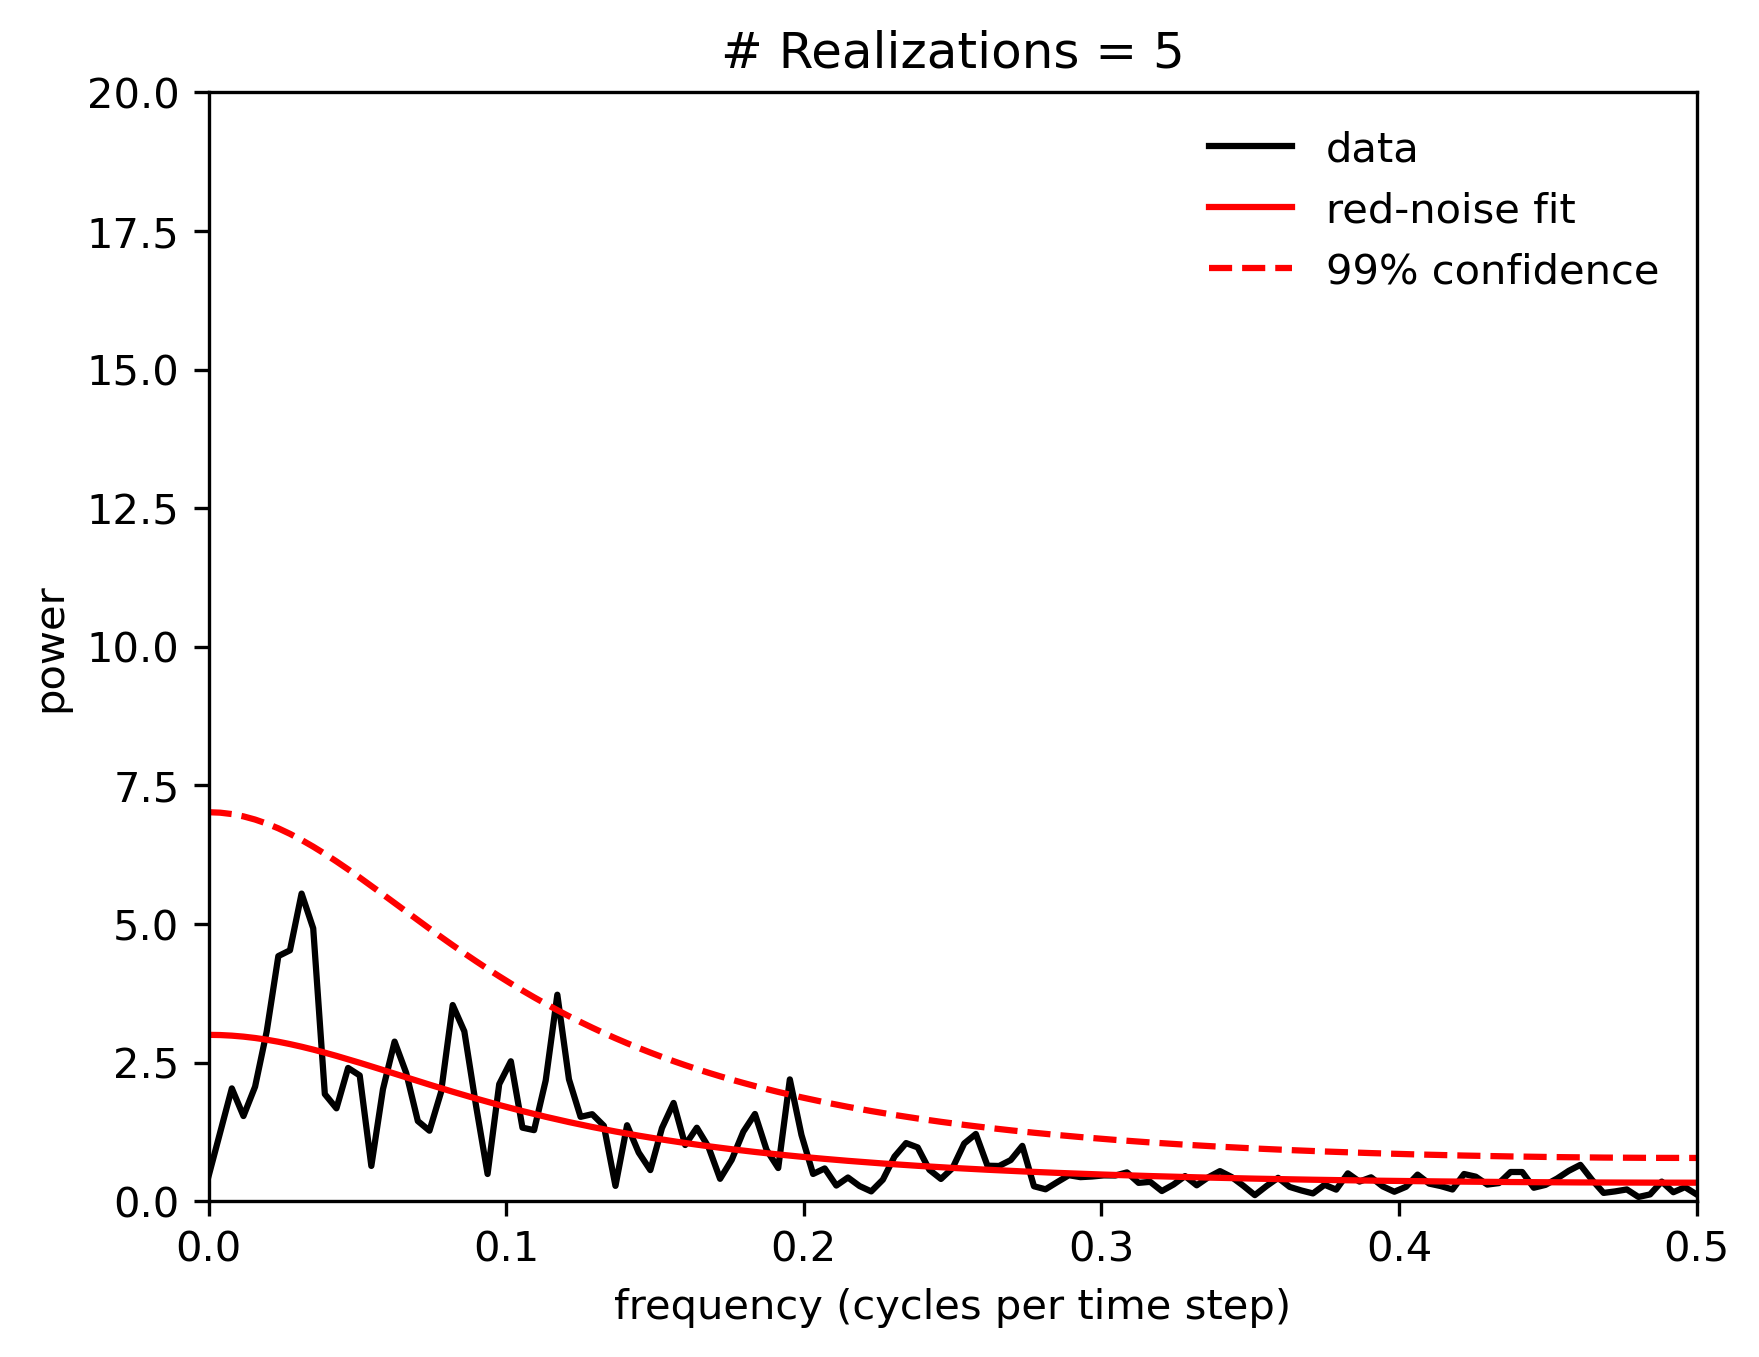

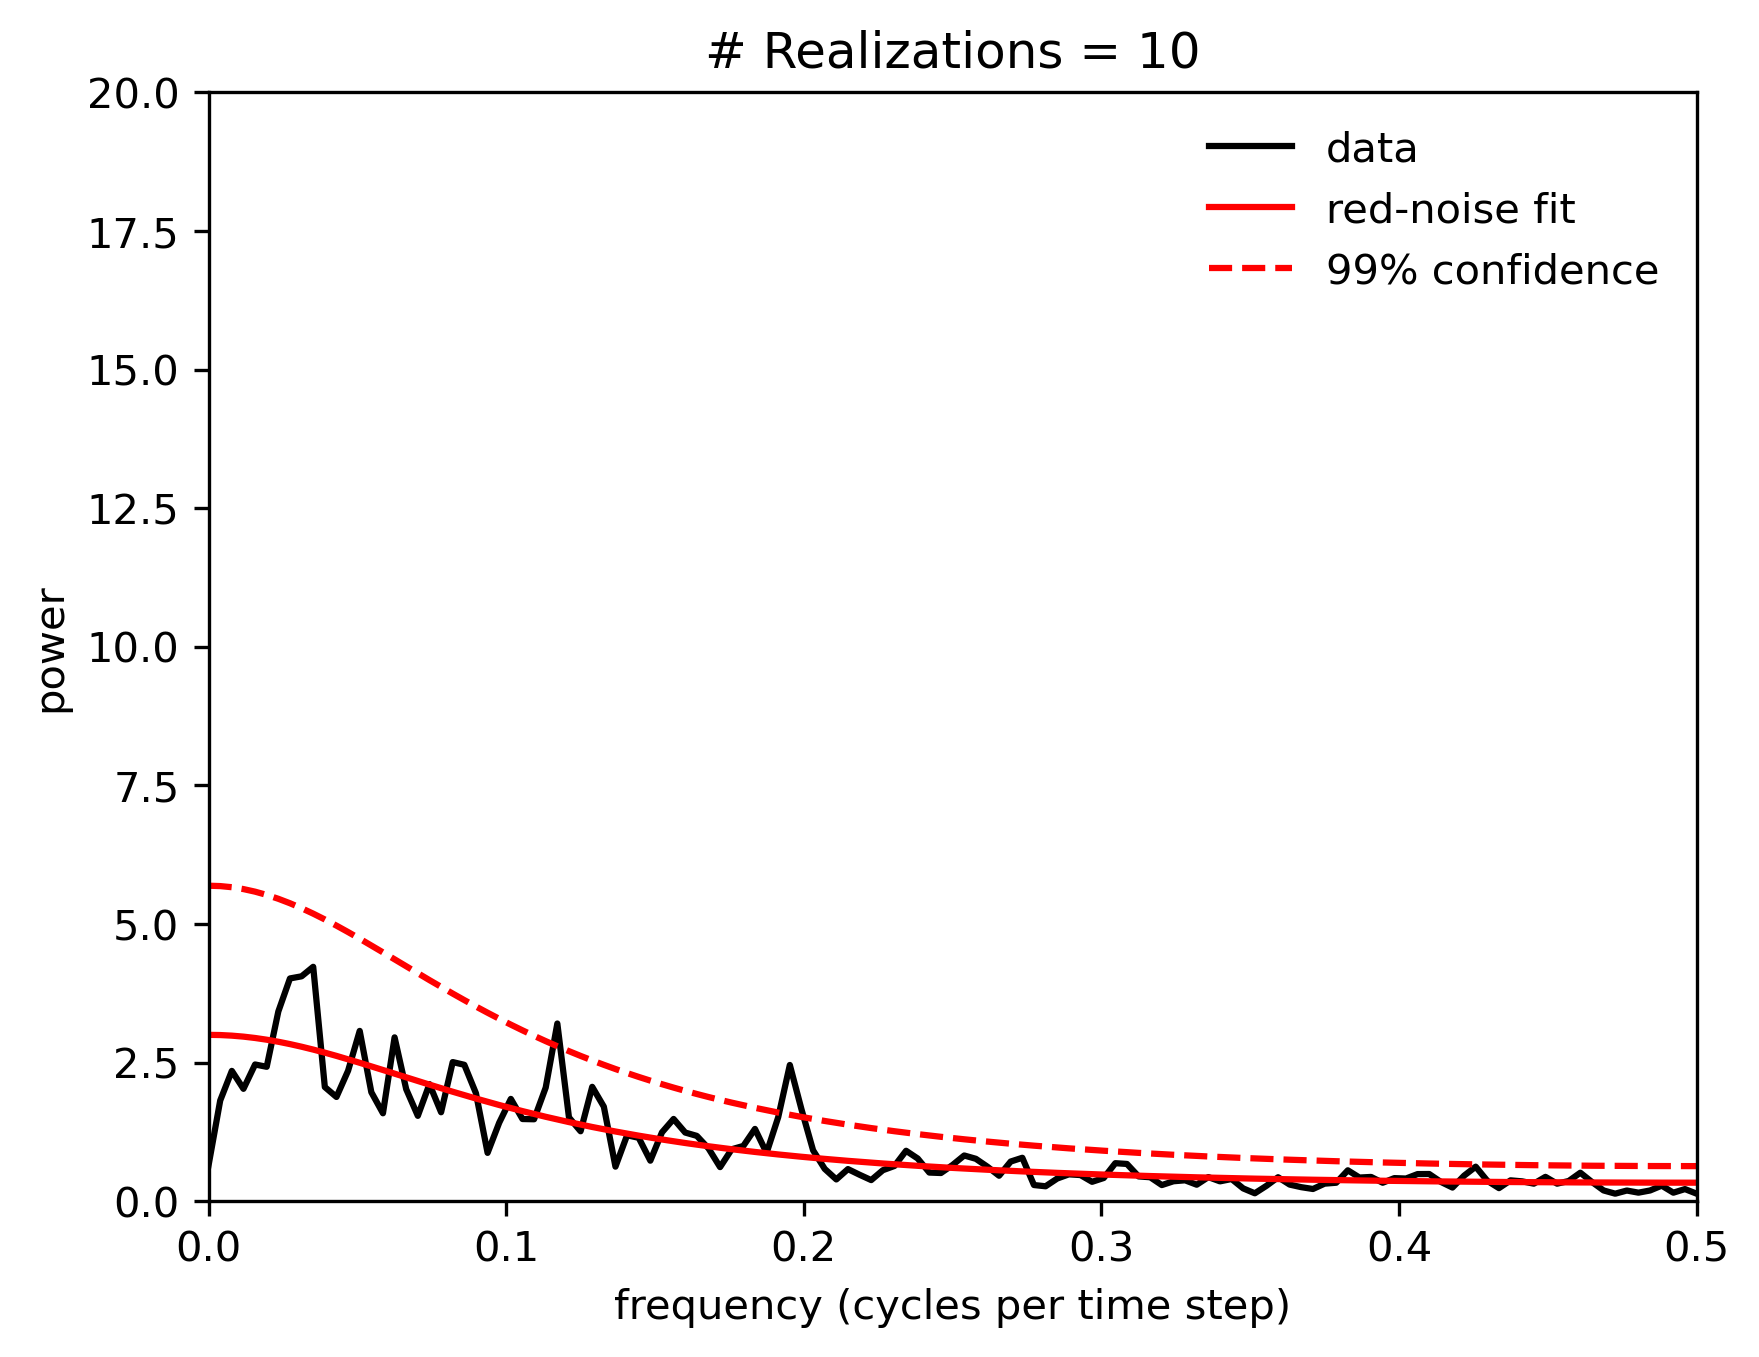

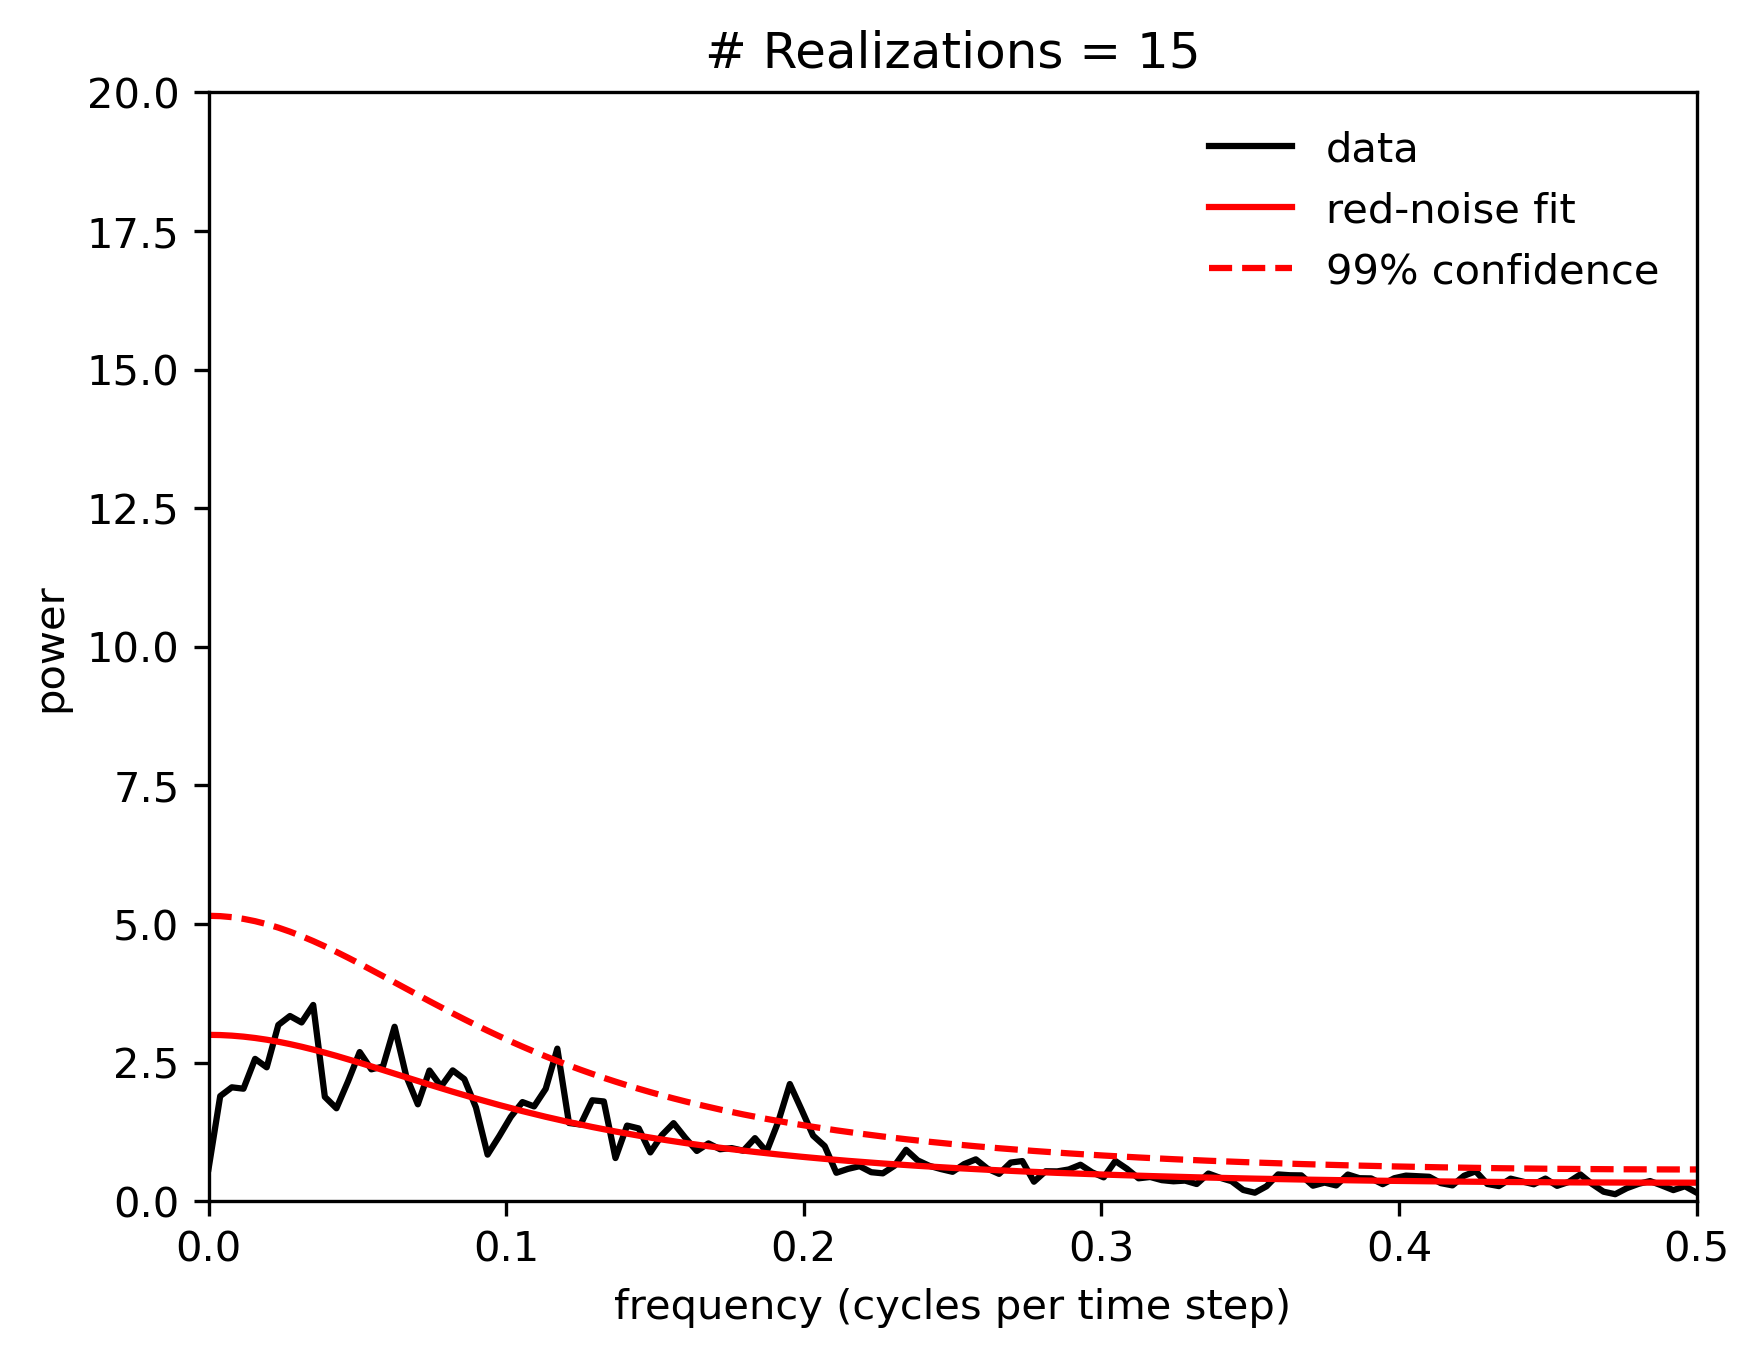

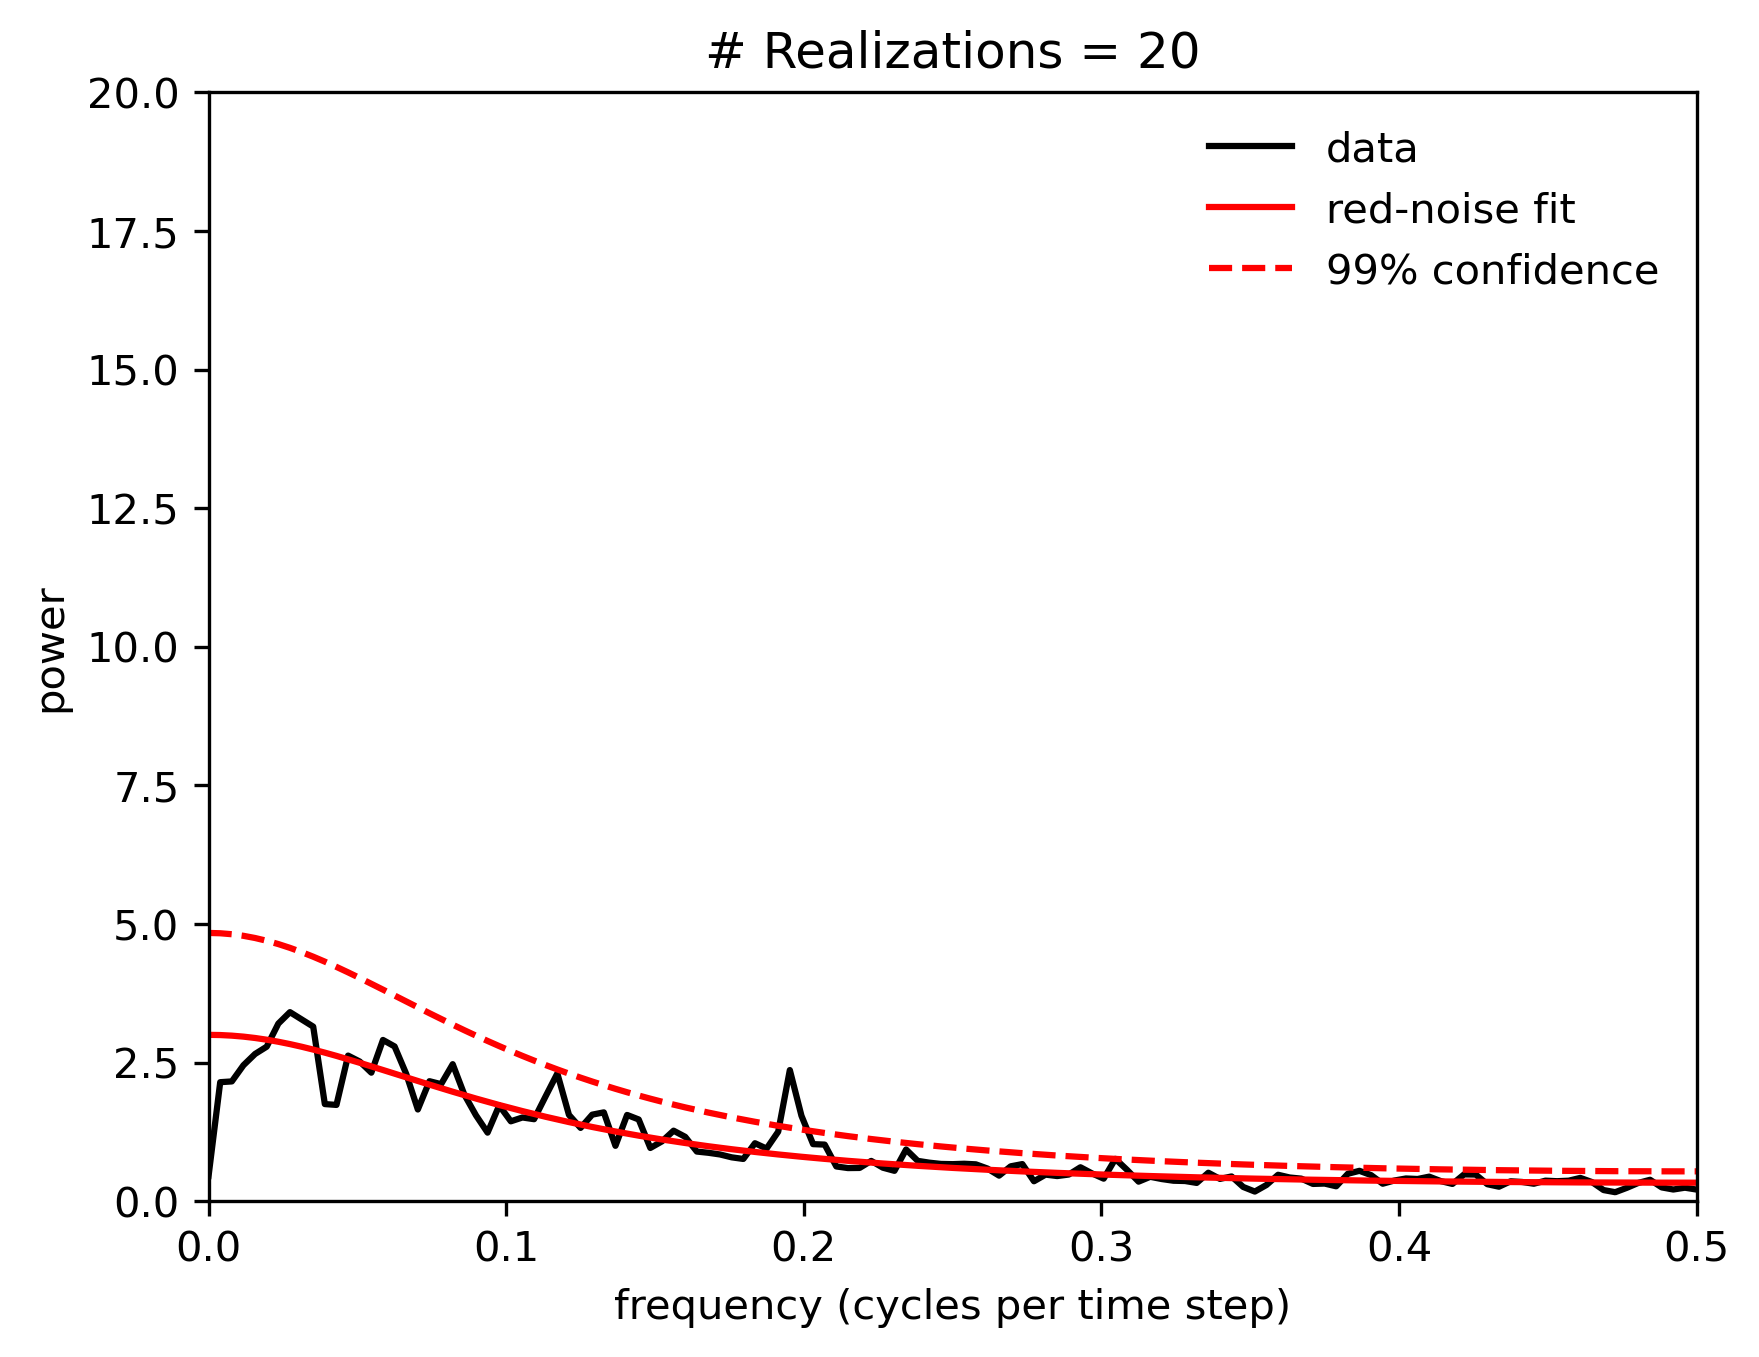

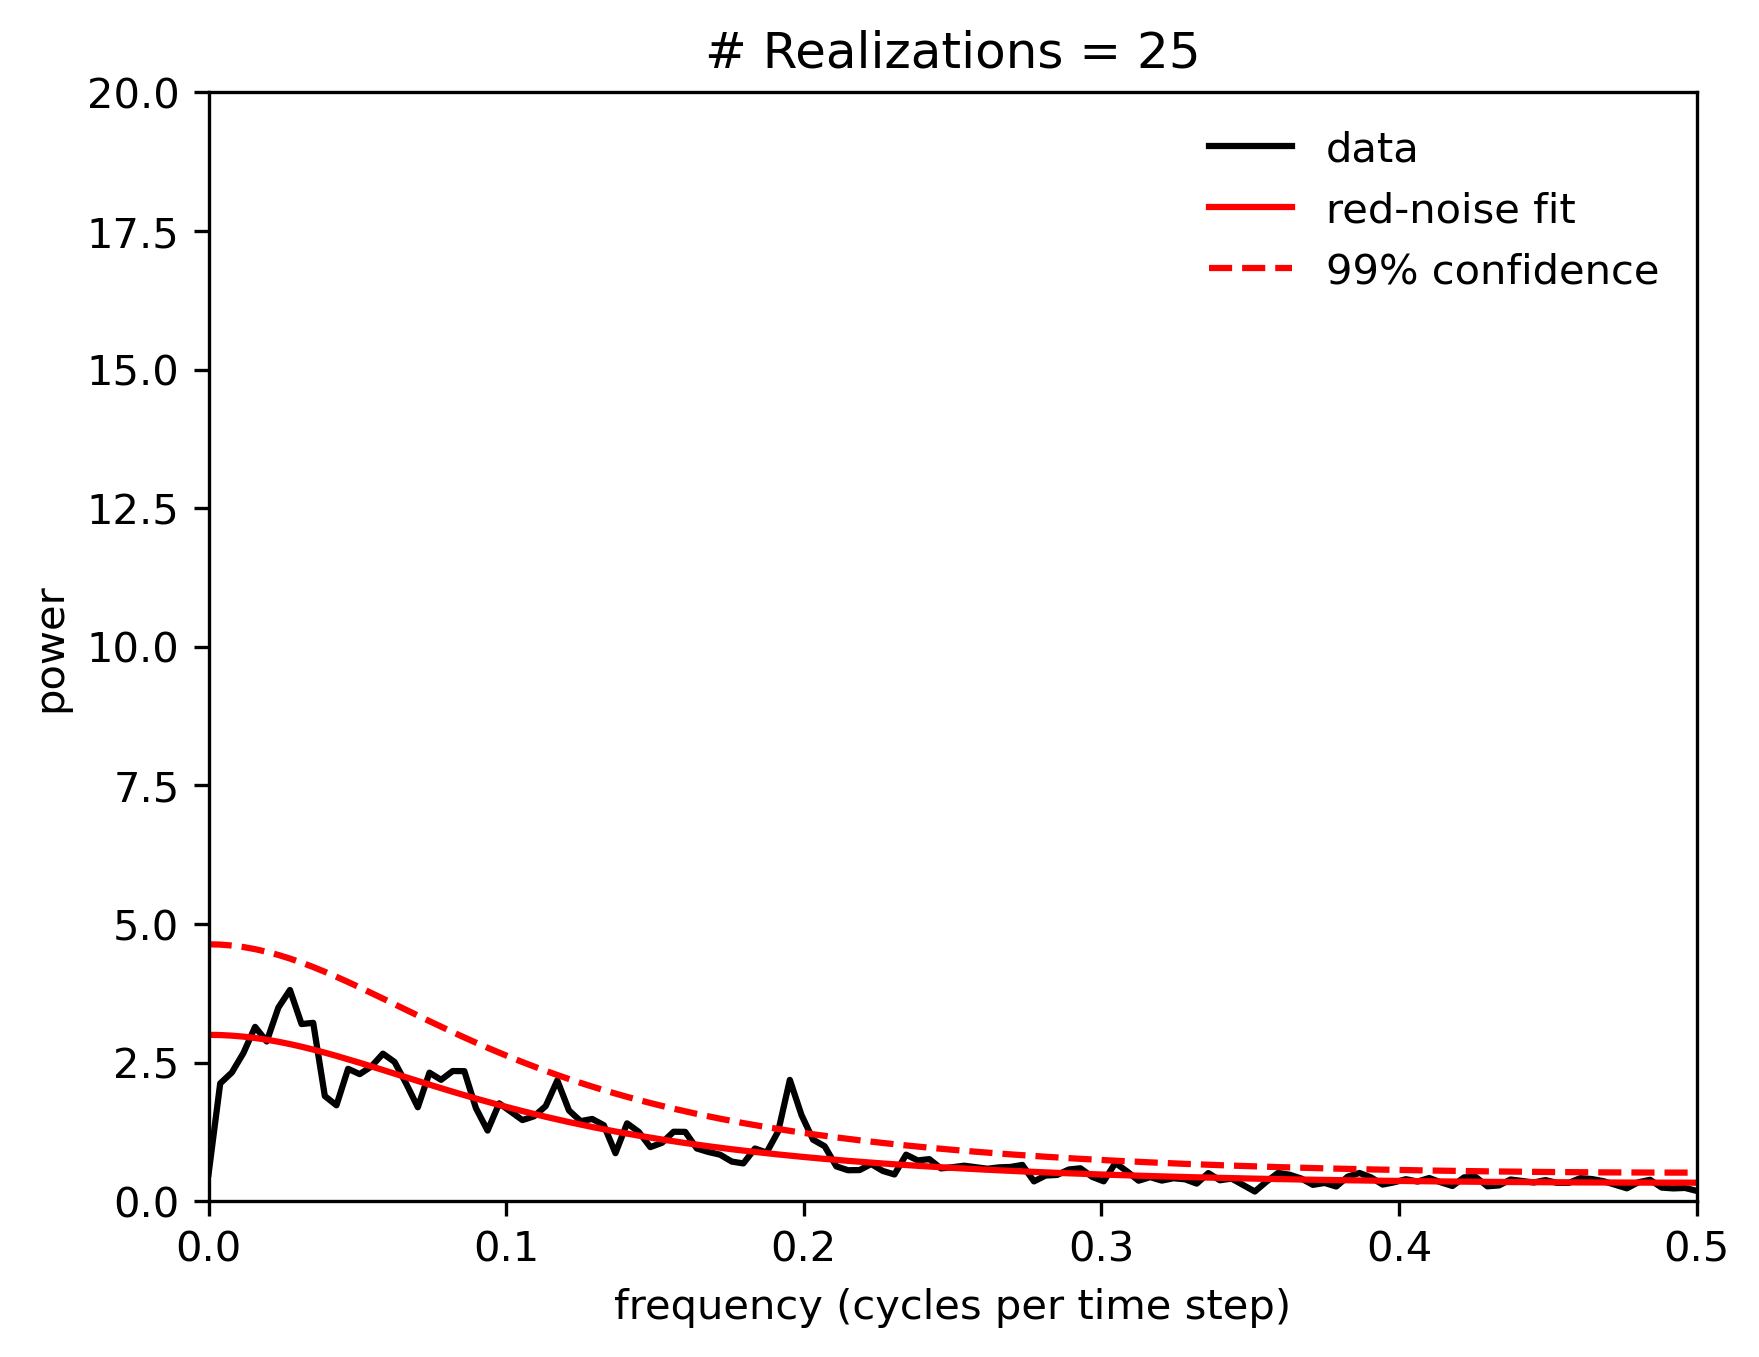

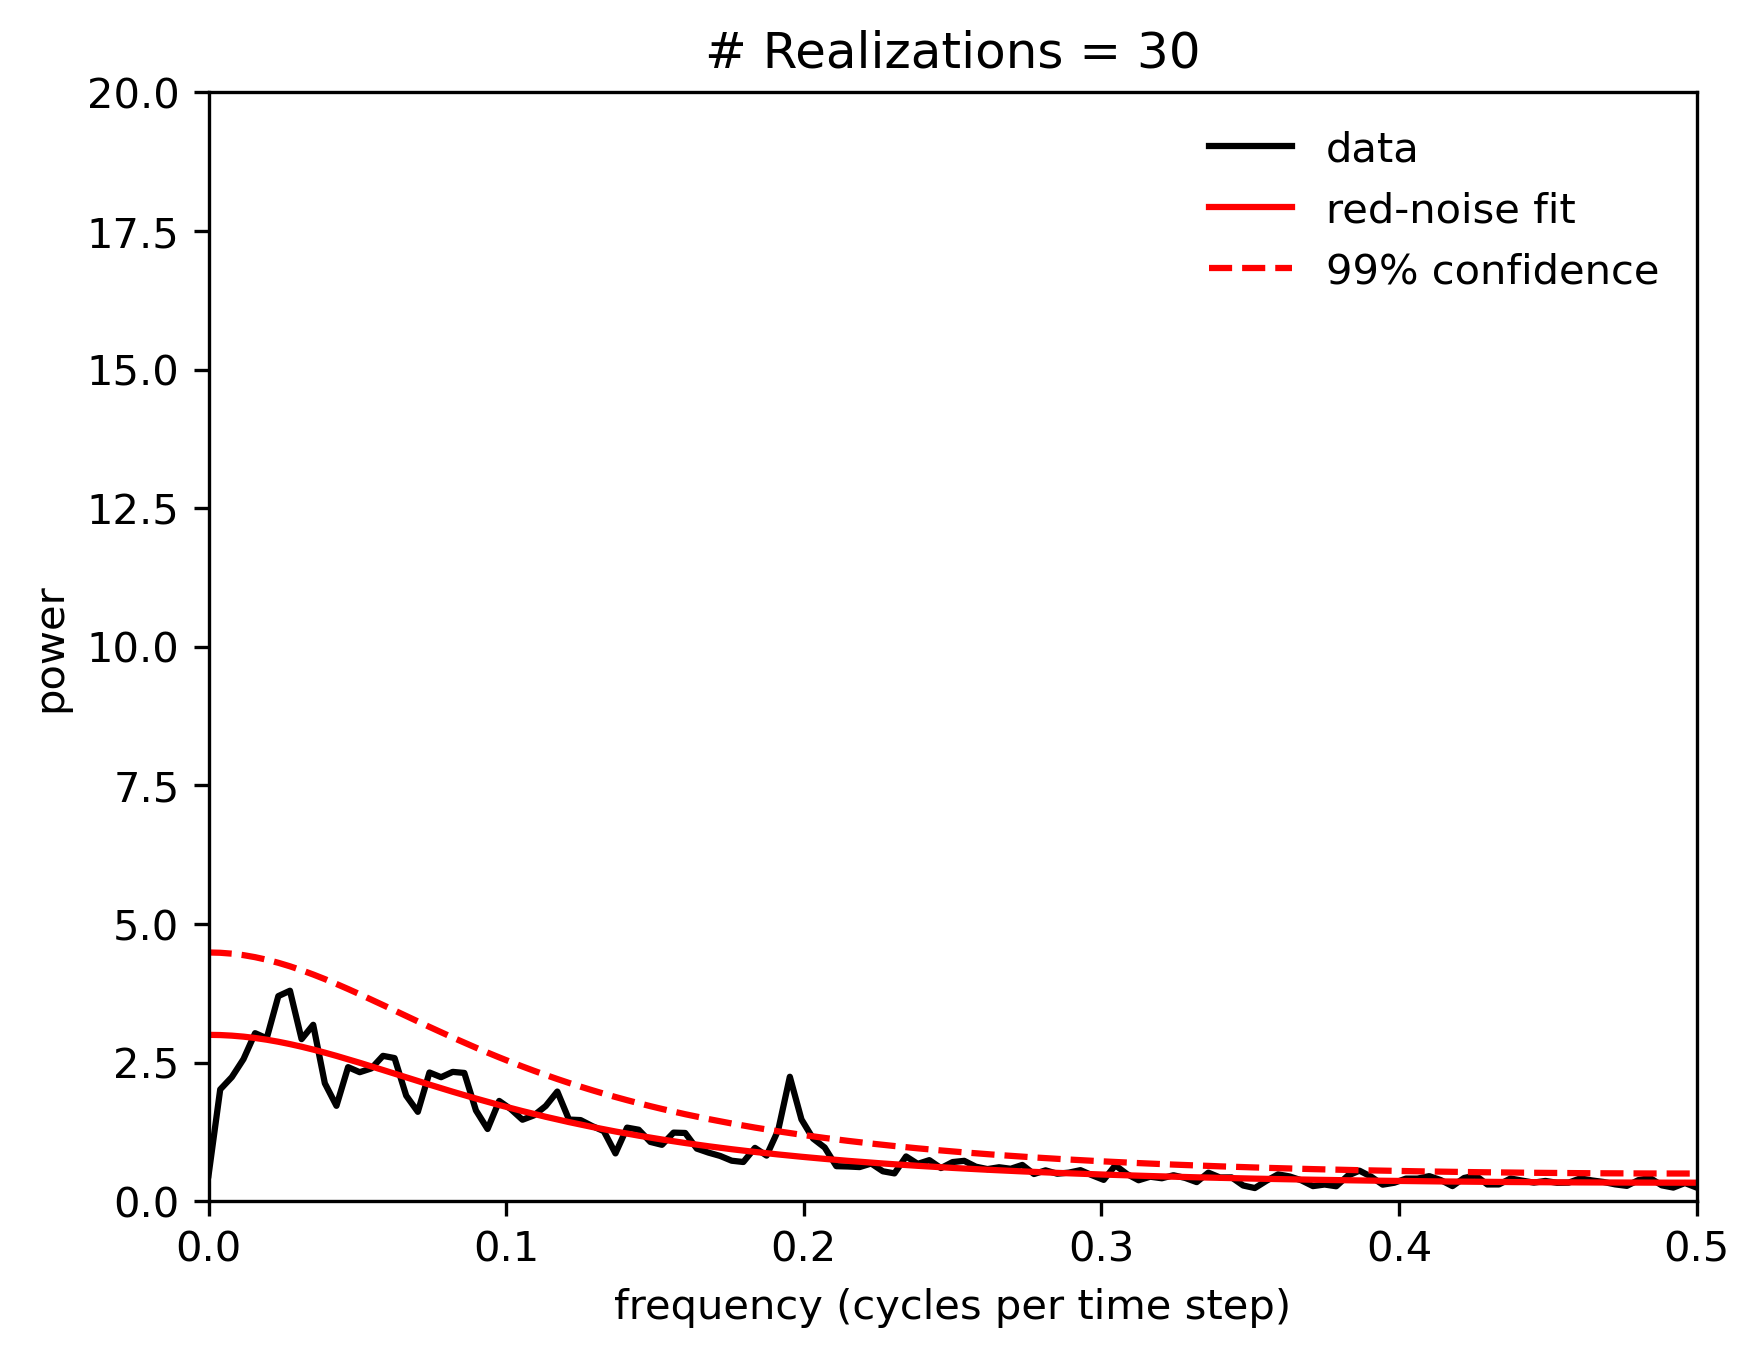

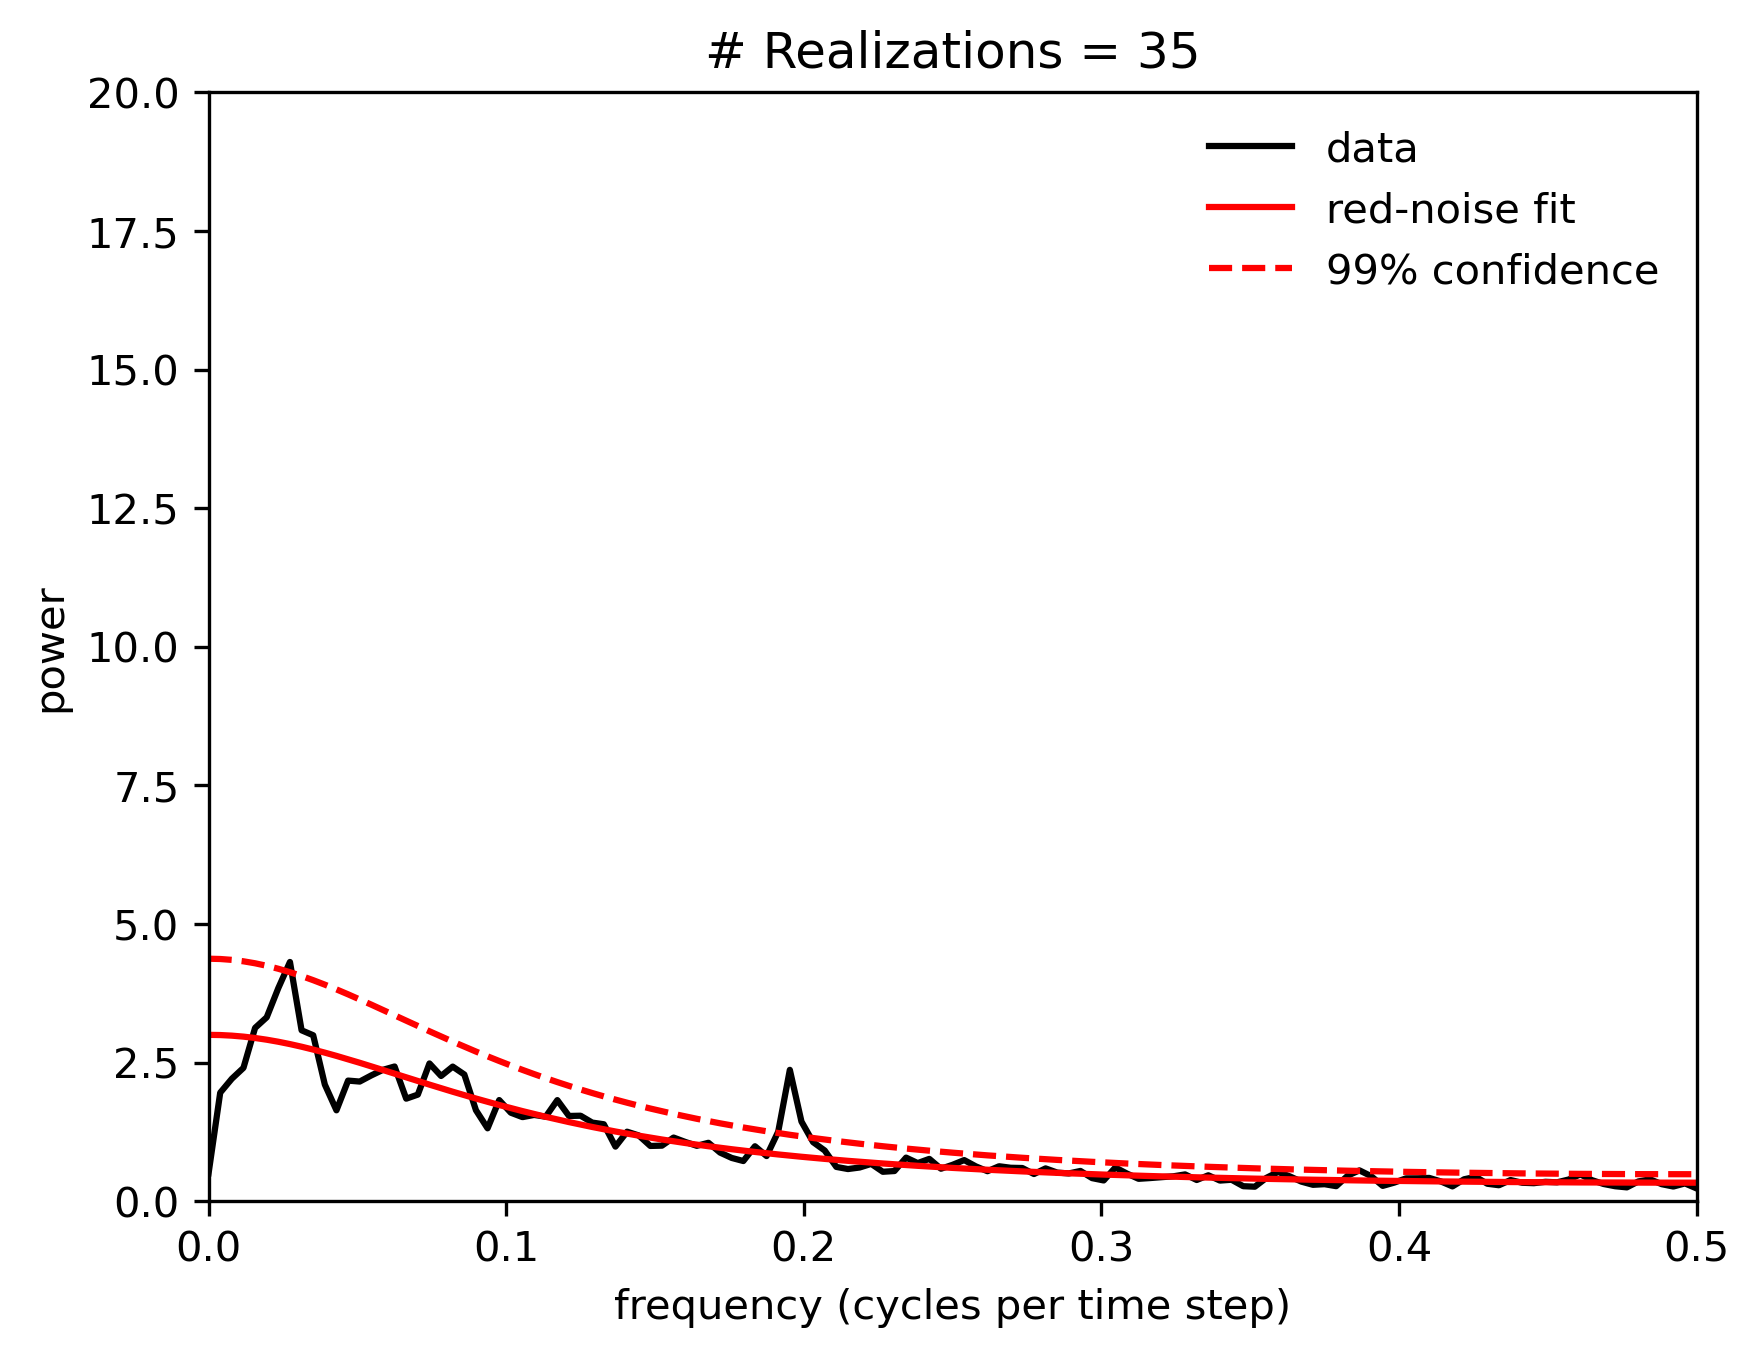

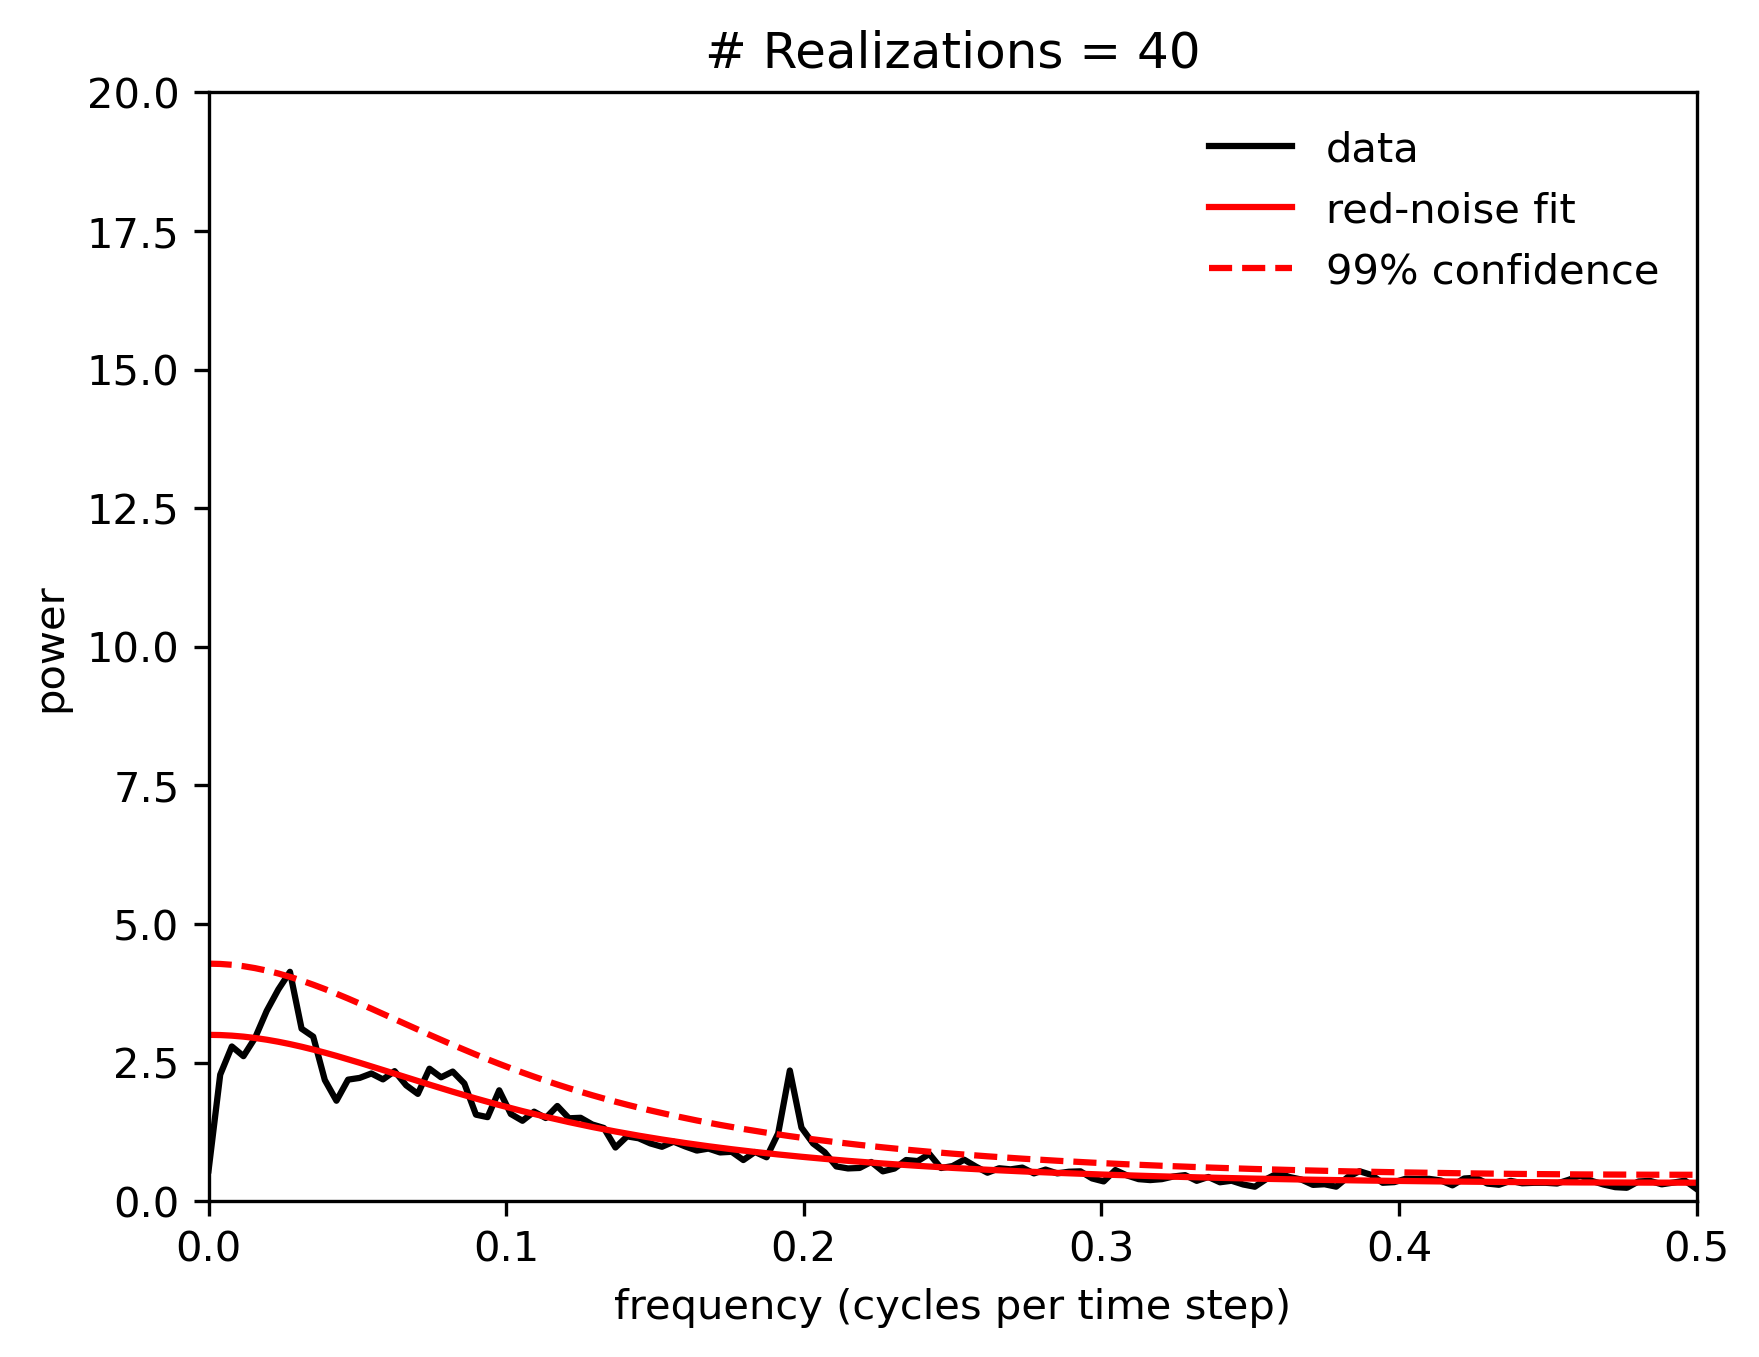

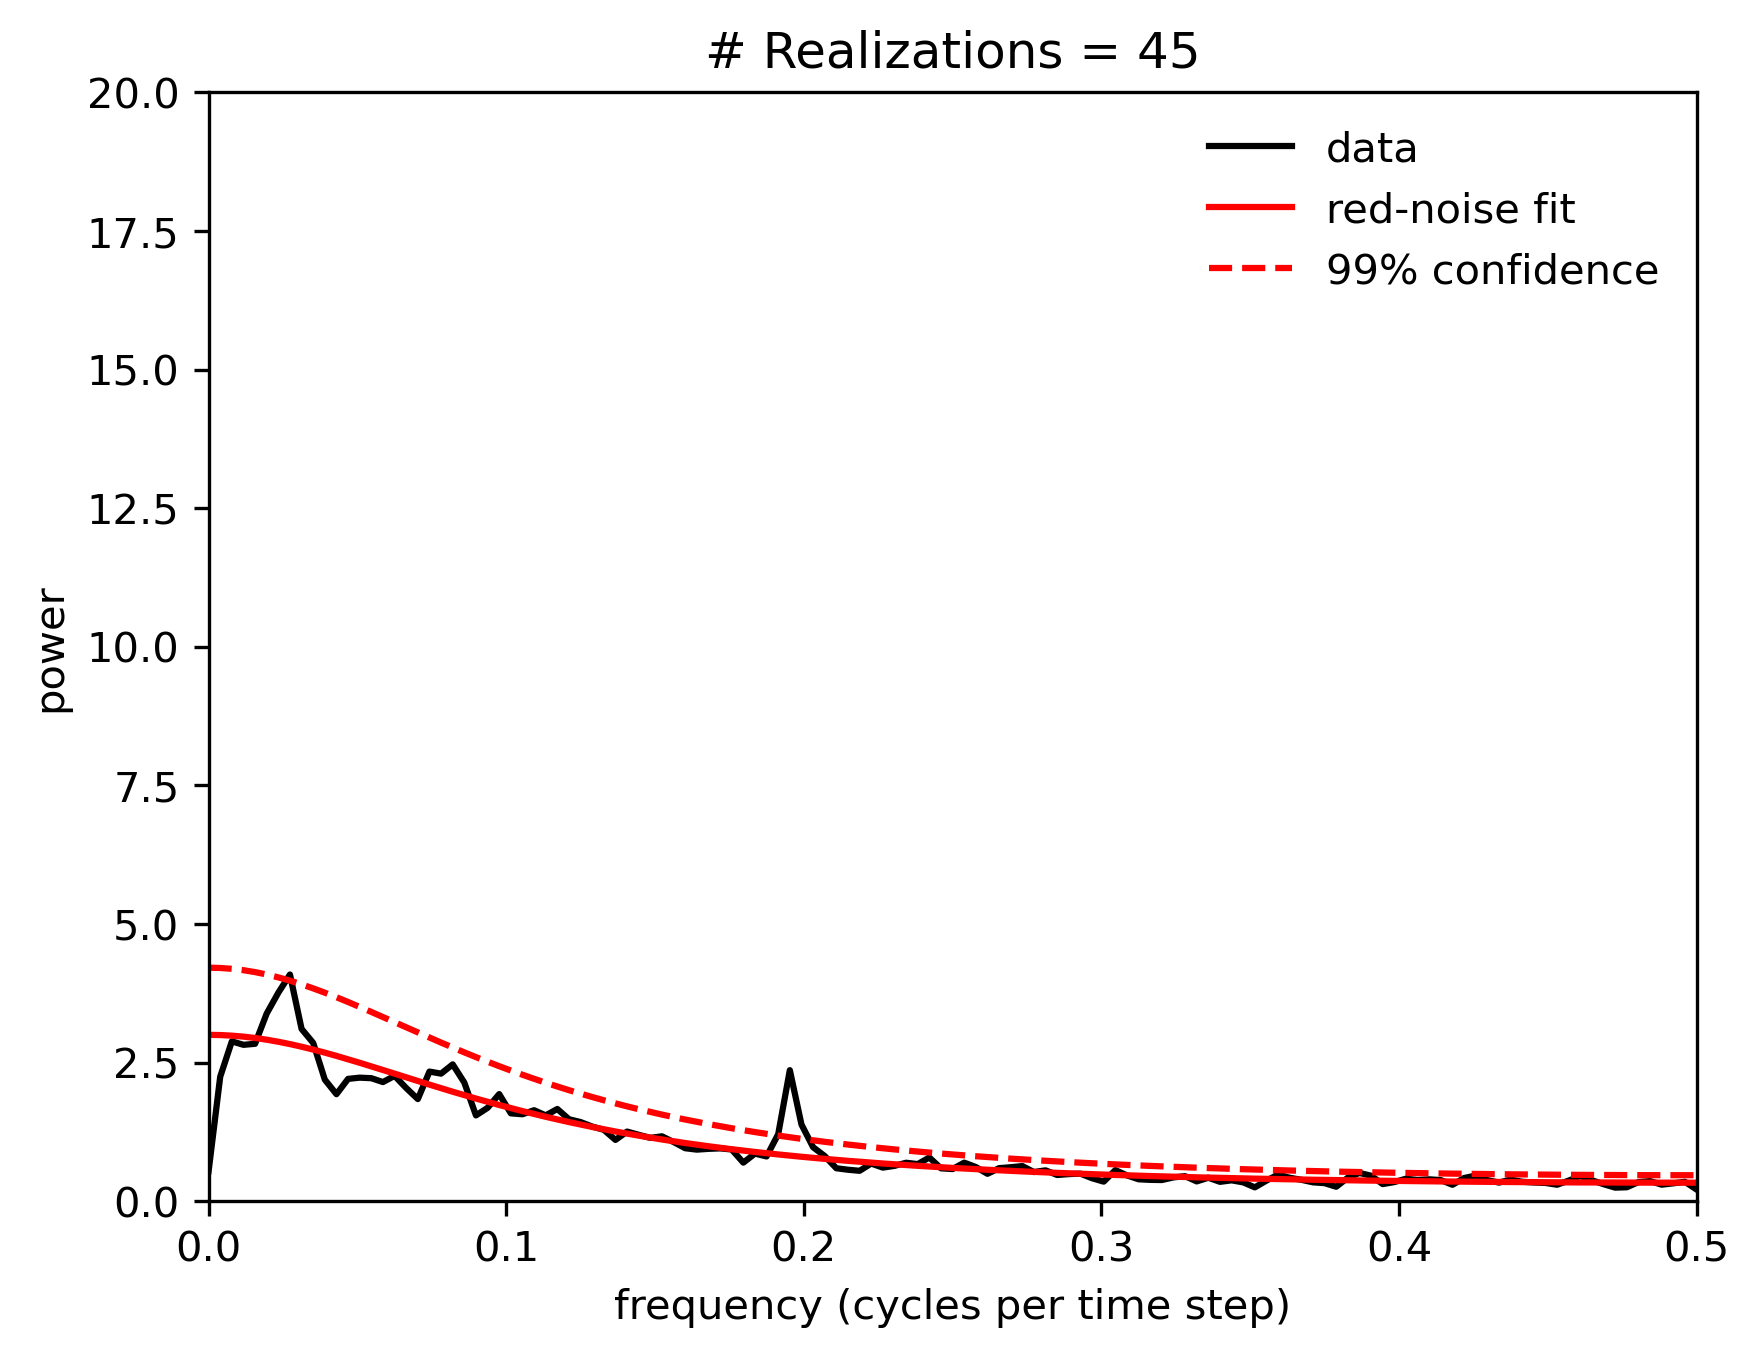

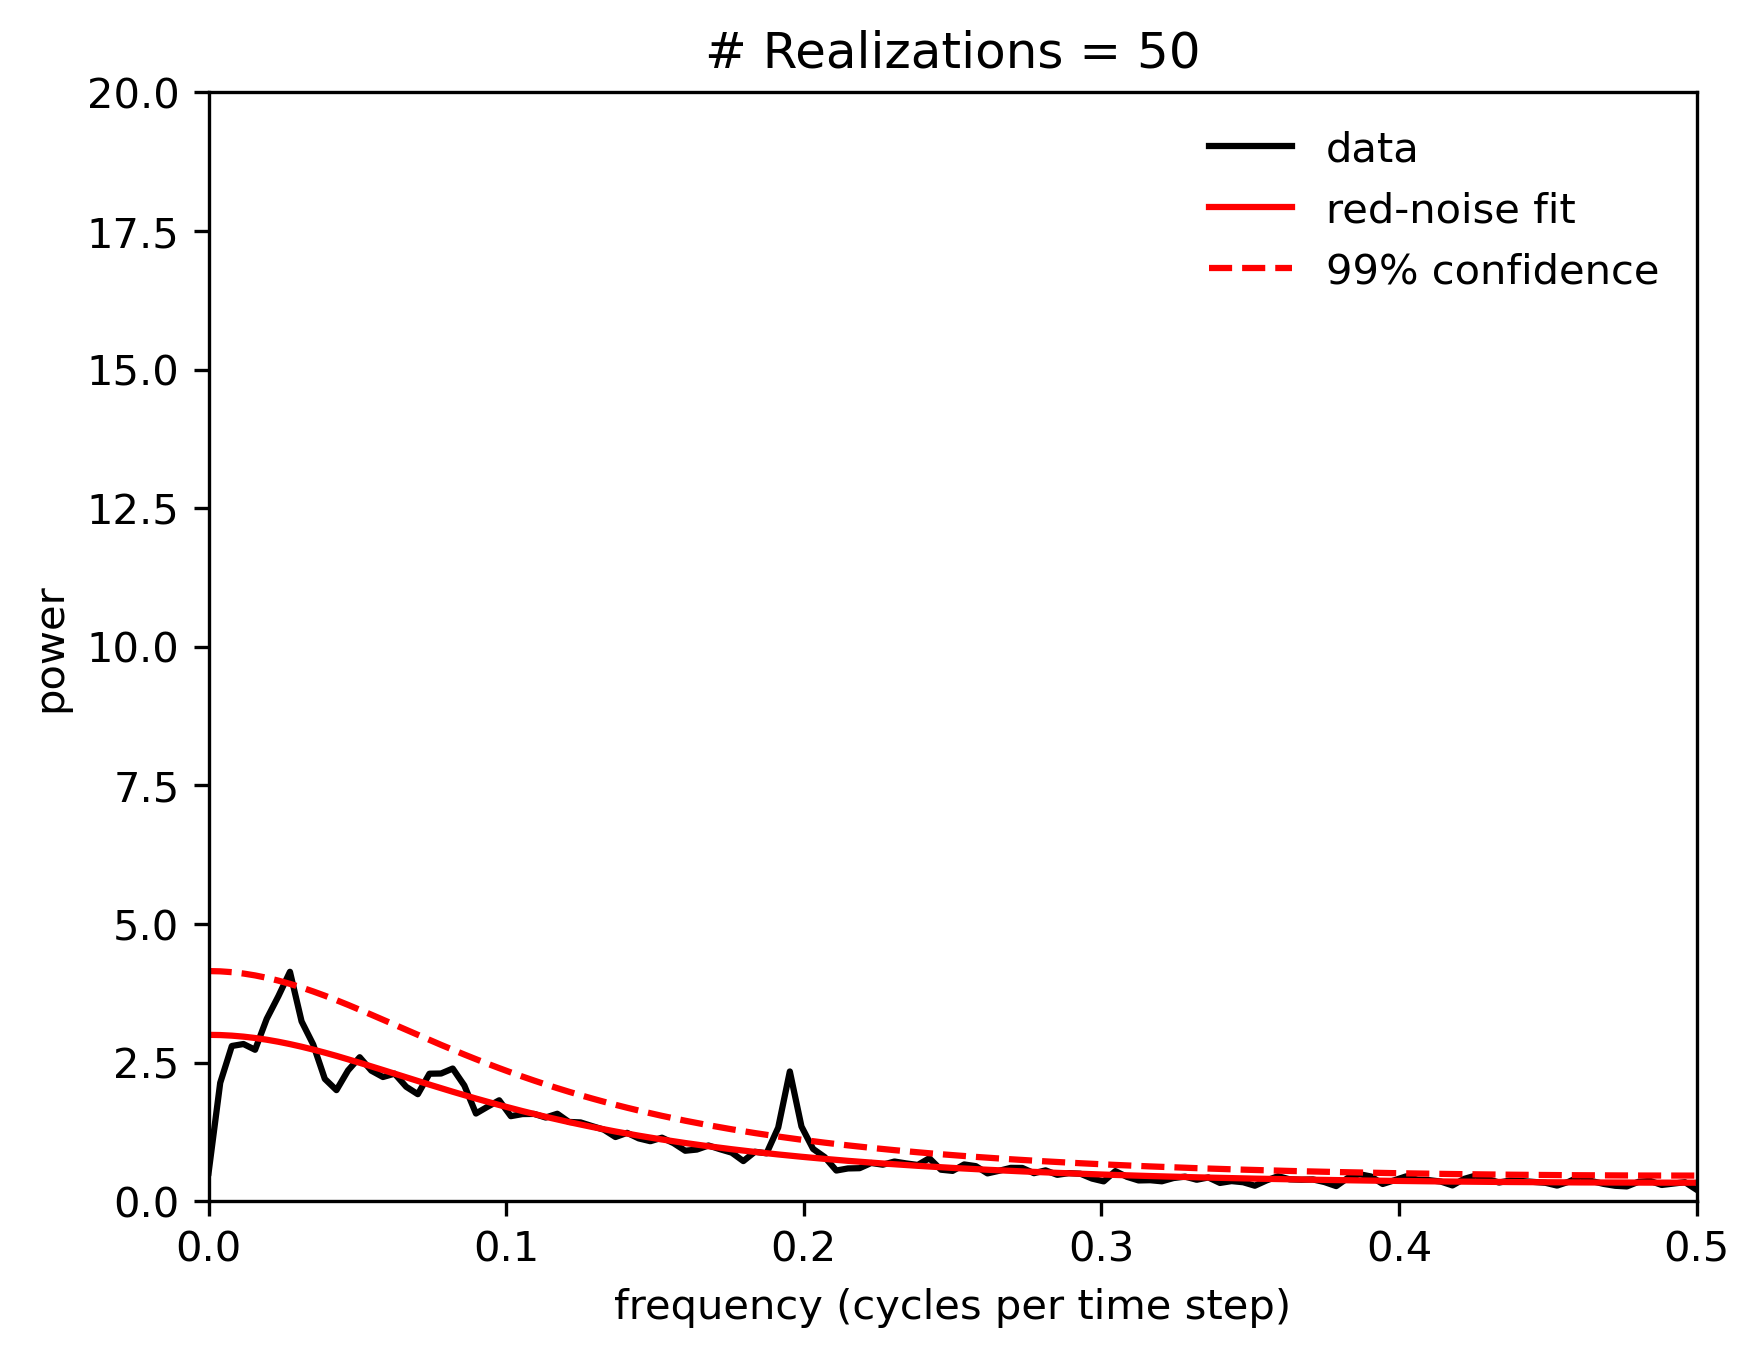

In [17]:
factor = np.sqrt(1.-alpha*alpha)
x = np.zeros(T,)

# loop realizations
for ir in np.arange(0,N,1):
    
    # make a fake red noise time series
    x = np.zeros(T,)
    x[0] = x[-1]*alpha + factor*np.random.randn()
    
    for j in np.arange(1,T,1):
        #add a cosine to our data to give it some additional power at a particular frequency of 50/256=0.2 cycles/time step
        x[j] = (x[j-1]*alpha 
                + factor*np.random.randn() 
                + 0.55*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*50./256.*j)
               )
    
    # for illustrative purposes, add a mean for x (comment out)
    x = x + 1.
    
    if(ir==0):
        plt.figure()
        plt.plot(x)
        plt.title('plot of chunk 1 of time series x(t)')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.show()
    
    # calculate the power spectrum using a hanning window
    p = sig.welch(x,window='hann', nperseg=T, detrend='constant') #detrend='constant', None, 'linear'
    if(ir==0):
        psum = p[1]
    else:
        psum = psum + p[1]

    # calculate average    
    pave = psum/(ir+1.0)
    #normalize the spectrum
    pave = pave/np.mean(pave)
 
    
    # calculate significance
    dof = 2.*(ir+1.)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = [fstat*m for m in rspec]
    
    if((ir+1.) % 5 == 0 or ir==0):       
        plt.figure()
        plt.xlabel('frequency (cycles per time step)')
        plt.ylabel('power')
        plt.title('# Realizations = ' + str(ir+1))
        plt.ylim(0,20.)
        plt.xlim(0,0.5)
        plt.plot(freq,pave,'-k', label = 'data')
        plt.plot(freq,rspec,'-', label = 'red-noise fit', color = 'red')
        plt.plot(freq,spec99,'--', label = '99% confidence', color = 'red')
        plt.legend(frameon = False)

plt.show()